tgb - 11/27/2019 - The goal of this network is to reinterpolate the NN in epsilon vertical coordinates back to the host grid to compare its performances with the pressure-gridded model

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Calculate outputs of eps NN

In [7]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)
PHQEPS_idx = slice(0,100)
TPHYSTNDEPS_idx = slice(100,200)

## 1.1) Define models

In [26]:
config_fn = ['/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/104_PostProc.yml',
            '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/132_PostProc.yml']
data0K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/104_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/131_valid.nc']
data4K_fn = ['/local/Tom.Beucler/SPCAM_PHYS/105_valid.nc',
            '/local/Tom.Beucler/SPCAM_PHYS/131_valid.nc']
NNarray = ['POG104','POG131']
NNname = ['RH T','RHeps Teps']

In [27]:
NN = {}; md0 = {}; md4 = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.hdf5'
    #NN[NNs] = load_model(path,custom_objects=dict_lay)
    NN[NNs] = load_model(path)
    md0[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data0K_fn[i])
    md4[NNs] = ModelDiagnostics(NN[NNs],config_fn[i],data4K_fn[i])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  POG104


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  POG131


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


## 1.2) Evaluate NN on samples

In [28]:
lat_ind = np.arange(0,64)
iini = 50
iend = 100

for isim in range(1):
    print('isim=',isim)
    if isim==0: md = md0
    elif isim==1: md = md4
    diagno = {} # Diagnostics structure
    diagno['truth'] = {} # Diagnostics structure for the truth
    for i,NNs in enumerate([NNarray[1]]):
        diagno[NNs] = {} # Diagnostics structure for each NN
        for itime in tqdm(np.arange(iini,iend)):
            # Get input, prediction and truth from NN
            inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
            # Get convective heating and moistening for each NN
            if itime==iini:
                if i==0:
                    diagno['truth']['PHQEPS'] = md[NNs].reshape_ngeo(truth[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                    diagno['truth']['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(truth[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['PHQEPS'] = md[NNs].reshape_ngeo(p[:,PHQEPS_idx])[lat_ind,:,:,np.newaxis]
                diagno[NNs]['TPHYSTNDEPS'] = md[NNs].reshape_ngeo(p[:,TPHYSTNDEPS_idx])[lat_ind,:,:,np.newaxis]
            else:
                for istr,field in enumerate(['PHQEPS','TPHYSTNDEPS']):
                    if field=='PHQEPS': ind_field = PHQEPS_idx
                    elif field=='TPHYSTNDEPS': ind_field = TPHYSTNDEPS_idx
                    diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                         md[NNs].reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                        axis=3)
                    if i==0:
                        diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                                 md[NNs].reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                axis=3)
    if isim==0: diagno0 = diagno
    elif isim==1: diagno4 = diagno

isim= 0


In [29]:
eps_res = 100
eps_NN = np.linspace(0,1,eps_res)

In [30]:
diagno['truth']['PHQEPS'].shape

(64, 128, 100, 50)

Text(0, 0.5, 'eps')

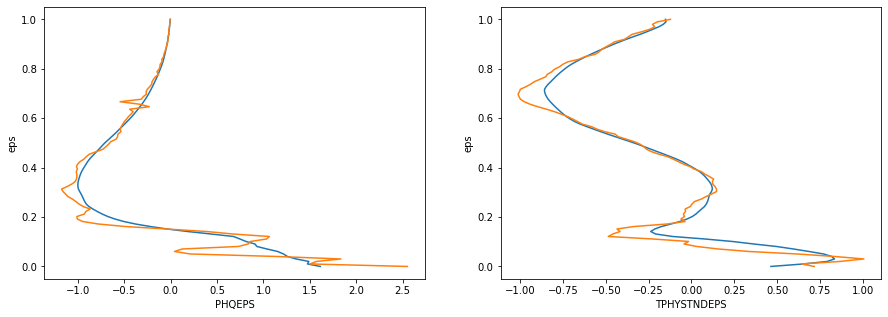

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.mean(diagno['truth']['PHQEPS'],axis=(0,1,3)),eps_NN)
plt.plot(np.mean(diagno[NNs]['PHQEPS'],axis=(0,1,3)),eps_NN)
plt.xlabel('PHQEPS')
plt.ylabel('eps')

plt.subplot(1,2,2)
plt.plot(np.mean(diagno['truth']['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN)
plt.plot(np.mean(diagno[NNs]['TPHYSTNDEPS'],axis=(0,1,3)),eps_NN)
plt.xlabel('TPHYSTNDEPS')
plt.ylabel('eps')

# 2) Interpolate back and forth

In [41]:
iini = 5
iend = 10
for itime in tqdm(np.arange(iini,iend)):
    # Get input, prediction and truth from NN
    inp_norm104, p, truth = md['POG104'].get_inp_pred_truth(itime)  # [lat, lon, var, lev]

In [42]:
inp = inp_norm104*md['POG104'].valid_gen.input_transform.div+\
md['POG104'].valid_gen.input_transform.sub

In [43]:
# Load data
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_22_imin_TNS_logfit.pkl','rb')
imfit = pickle.load(hf)['logmodel'][0]
hf = open(pathPKL+'2019_11_22_eps_TNS_linfit.pkl','rb')
epfit = pickle.load(hf)['linmodel']

In [45]:
# Layer input
# x = The NN input 
# x.shape=(batch size,# inputs)
# Layer output
# x_interp = The NN input interpolated on the custom eps grid
# x_interp.shape=(batch size,custom eps grid size)
# Parameters
eps_res = 100
# eps_res = Resolution of the eps grid

x_test = inp
# 1) Generate eps grid for the neural network with vertical resolution eps_res
# and the interpolated input array
eps_NN = np.linspace(0,1,eps_res)
x_interp = np.zeros((x_test.shape[0],int(x_test.shape[1]+2*(eps_res-30))))

# 2) Extract temperature and moisture from input vector
q = x_test[:,:30]
T = x_test[:,30:60]

# 3) Calculates vertical interpolation domain [imin_eval:] and eps coordinate as a function of NS T = T[30]
for isample in range(T.shape[0]):
    x = T[isample,-1]
    imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                 imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                 imfit[4]*np.log10(x)**4)))
    eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
    # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
    eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
    eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))
    
# 4) Interpolate both T and q to the eps grid for the neural network
# 4.1) Thermodynamic profiles to interpolate
# tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
    T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
    q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
# 4.2) Interpolation using searchsorted and low-level weighting implementation
# The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
# If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
    iint = np.searchsorted(eps_eval,eps_NN)
    T_interp = np.where(iint<1,T_input[0],np.where(iint>(30-imin_eval-1),T_input[30-imin_eval-1],\
                                                   ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint-1]+\
                                                   ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*T_input[iint]))
    q_interp = np.where(iint<1,q_input[0],np.where(iint>(30-imin_eval-1),q_input[30-imin_eval-1],\
                                                   ((eps_eval[iint]-eps_NN)/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint-1]+\
                                                   ((eps_NN-eps_eval[iint-1])/(eps_eval[iint]-eps_eval[iint-1]))*q_input[iint]))

# 5) Return the interpolated input vector x_interp
    x_interp[isample,:] = np.concatenate((q_interp,T_interp,x_test[isample,60:]))

In [51]:
inp_norm131 = (x_interp-md['POG131'].valid_gen.input_transform.sub)/\
md['POG131'].valid_gen.input_transform.div

In [53]:
pred131 = md['POG131'].model.predict_on_batch(inp_norm131)

In [58]:
PS = 1e5
eps_res = 1e2
dP = PS/eps_res

In [59]:
predeps = pred131/md['POG131'].valid_gen.output_transform.scale

In [69]:
y = np.zeros((T.shape[0],64))
for isample in range(T.shape[0]):
    x = T[isample,-1]
    imin_eval = int(np.rint(10**(imfit[0]*np.log10(x)**0+imfit[1]*np.log10(x)**1+\
                                 imfit[2]*np.log10(x)**2+imfit[3]*np.log10(x)**3+\
                                 imfit[4]*np.log10(x)**4)))
    eps_eval = epfit[:,0]*x**0+epfit[:,1]*x**1+epfit[:,2]*x**2+epfit[:,3]*x**3+epfit[:,4]*x**4
    # tgb - 11/23/2019 - Adds dummy 1 at the end because np.where evaluates y output even if condition false and not returning y
    eps_test = np.minimum(1,np.maximum(eps_eval,0))[imin_eval:]
    eps_eval = np.concatenate((np.minimum(1,np.maximum(eps_eval,0))[imin_eval:][::-1],[1]))
    
# 4) Interpolate both T and q to the eps grid for the neural network
# 4.1) Thermodynamic profiles to interpolate
# tgb - 11/23/2019 - Adds dummy zero at the end because np.where evaluates y output even if condition false and not returning y
    dqdt_output = predeps[isample,:100]
    dTdt_output = predeps[isample,100:200]
    #T_input = np.concatenate((T[isample,imin_eval:][::-1],[0]))
    #q_input = np.concatenate((q[isample,imin_eval:][::-1],[0]))
# 4.2) Interpolation using searchsorted and low-level weighting implementation
# The goal is to mimic T_interp = np.interp(x=eps_ref,xp=eps_eval,fp=T_input)
# If left then T_input[0], if right then T_input[-1], else weighted average of T_input[iint-1] and T_input[iint]
    iint = np.searchsorted(eps_NN,eps_eval)
    dTdt_interp = np.where(iint<1,dTdt_output[0],np.where(iint>99,dTdt_output[-1],\
                                                          ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint-1]+\
                                                          ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dTdt_output[iint]))
    dTdt_interp = np.concatenate((dTdt_interp,np.zeros(imin_eval-1,)))[::-1]
    dqdt_interp = np.where(iint<1,dqdt_output[0],np.where(iint>99,dqdt_output[-1],\
                                                          ((eps_NN[iint]-eps_eval)/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint-1]+\
                                                          ((eps_eval-eps_NN[iint-1])/(eps_NN[iint]-eps_NN[iint-1]))*dqdt_output[iint]))
    dqdt_interp = np.concatenate((dqdt_interp,np.zeros(imin_eval-1,)))[::-1]
# 5) Return the output vector y
    y[isample,:] = np.concatenate((dqdt_interp,dTdt_interp,predeps[isample,200:204]))

In [75]:
# Convert y to W/m2 to compare them to the truth
y *= md['POG104'].valid_gen.output_transform.scale

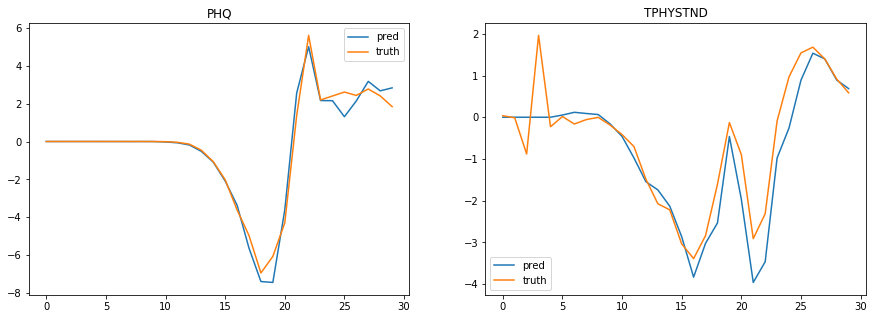

In [85]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('PHQ')
plt.plot(np.mean(y[:,:30],axis=0),label='pred')
plt.plot(np.mean(truth[:,:30],axis=0),label='truth')
plt.legend()

plt.subplot(1,2,2)
plt.title('TPHYSTND')
plt.plot(np.mean(y[:,30:60],axis=0),label='pred')
plt.plot(np.mean(truth[:,30:60],axis=0),label='truth')
plt.legend()

# 3) Code for several timesteps

In [ ]:
iini = 5
iend = 10
for itime in tqdm(np.arange(iini,iend)):
    # Get input, prediction and truth from NN
    inp_norm104, p, truth = md['POG104'].get_inp_pred_truth(itime)  # [lat, lon, var, lev]